# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [2]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [3]:
from lib.dataeng import Etl

In [4]:
etl = Etl()
etl.repo

'/home/benjamin/Downloads/'

In [5]:
df_weight_raw = etl._extract_poids() # extrait toutes les mesures de poids


Le fichier poids le plus récent est : data_BEN_1710562840.zip, parmi :
data_BEN_1710491098.zip
data_BEN_1710562840.zip
data_BEN_1710308314.zip
data_BEN_1710391640.zip


In [6]:
df_weight = df_weight_raw.groupby(['Date']).mean()

In [7]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2024-03-02,71.781333,11.570667,3.011333,57.180000,40.412667,0.161192,1670.5504
2024-03-03,72.500000,12.039333,3.022667,57.422667,40.555333,0.166059,1675.9504
2024-03-04,71.822000,11.679333,3.008000,57.116667,40.323333,0.162614,1669.0816
2024-03-05,71.934000,12.125333,2.988667,56.804000,39.916000,0.168562,1661.8672
2024-03-06,71.974000,11.616000,3.018000,57.320000,40.545333,0.161391,1673.7328
2024-03-07,71.593333,11.222000,3.024000,57.330667,40.659333,0.156746,1674.0208
2024-03-08,72.173125,11.122500,3.061250,57.973125,41.372500,0.154108,1688.6935
2024-03-09,73.181875,10.396875,3.171250,59.597500,43.471875,0.142068,1726.1560
2024-03-10,72.686000,11.529333,3.064000,58.078000,41.352667,0.158617,1690.9840


In [8]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2024-03-02,72.299333,12.233714,3.002476,57.047524,40.147810,0.169197,1667.417371
2024-03-03,72.216190,12.174857,3.001524,57.024381,40.136286,0.168581,1666.892800
2024-03-04,72.093905,12.072095,3.000952,57.005048,40.137619,0.167440,1666.471086
2024-03-05,71.990190,12.019048,2.998286,56.956857,40.098190,0.166951,1665.376686
2024-03-06,71.977238,11.907524,3.003333,57.049429,40.212190,0.165433,1667.505829
2024-03-07,71.941714,11.739810,3.010952,57.173810,40.372095,0.163176,1670.361143
2024-03-08,71.968256,11.625024,3.019131,57.306732,40.540643,0.161524,1673.413814
2024-03-09,72.168333,11.457339,3.041976,57.652089,40.977673,0.158792,1681.357471
2024-03-10,72.194905,11.384482,3.047881,57.745708,41.091577,0.157729,1683.505129


In [9]:
df_food_raw = etl._extract_food()  # calories par jour par repas


Le fichier food le plus récent est : File-Export-2020-08-03-to-2024-03-16.zip, parmi
File-Export-2020-08-03-to-2024-03-13.zip
File-Export-2020-08-03-to-2024-03-14.zip
File-Export-2020-08-03-to-2024-03-16.zip
File-Export-2020-08-03-to-2024-03-15.zip


In [10]:
df_food = df_food_raw.groupby(['Date']).sum(numeric_only=True)

In [11]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2024-03-01,1626.2,37.4,121.9,202.6
2024-03-02,1666.7,41.8,140.0,189.5
2024-03-03,1761.1,36.3,167.5,195.3
2024-03-04,1675.1,35.5,114.2,232.0
2024-03-05,1620.8,45.4,136.3,178.4
2024-03-06,1652.2,49.4,106.9,178.2
2024-03-07,1749.8,50.5,162.4,149.5
2024-03-08,3116.3,79.7,332.2,196.1
2024-03-09,2348.0,71.3,230.0,192.6


In [12]:
df_exos_raw = etl._extract_exos()


Le fichier exercices le plus récent est : polar-user-data-export_bd8a06c1-7cac-47fc-a1fe-71b374e61732.zip, parmi :
polar-user-data-export_bd8a06c1-7cac-47fc-a1fe-71b374e61732.zip
polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip


100%|██████████| 1924/1924 [01:19<00:00, 24.20it/s]


In [13]:
df_exos_total = df_exos_raw.groupby(['exo_date']).sum(numeric_only=True)

In [14]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
exo_date,,
2024-03-01,2280.0,213.0
2024-03-02,2340.0,154.0
2024-03-03,6600.0,552.0
2024-03-04,0.0,0.0
2024-03-05,4080.0,340.0
2024-03-06,1680.0,100.0
2024-03-07,2280.0,150.0
2024-03-08,7440.0,830.0
2024-03-09,1560.0,248.0


In [15]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
exo_date,,
2024-03-01,2589.379286,271.285714
2024-03-02,2588.571429,272.000000
2024-03-03,2657.142857,258.142857
2024-03-04,2657.142857,258.142857
2024-03-05,2802.857143,265.000000
2024-03-06,2837.142857,247.428571
2024-03-07,2751.428571,215.571429
2024-03-08,3488.571429,303.714286
2024-03-09,3377.142857,317.142857


In [16]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [17]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [18]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [19]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2024-03-01,71.987333,11.926000,3.004000,57.042667,40.192667,0.165667,1667.3248,1626.2,37.4,121.9,202.6,2280.0,213.0,169.001151,1836.325951,-210.125951
2024-03-02,71.781333,11.570667,3.011333,57.180000,40.412667,0.161192,1670.5504,1666.7,41.8,140.0,189.5,2340.0,154.0,108.755927,1779.306327,-112.606327
2024-03-03,72.500000,12.039333,3.022667,57.422667,40.555333,0.166059,1675.9504,1761.1,36.3,167.5,195.3,6600.0,552.0,423.976011,2099.926411,-338.826411
2024-03-04,71.822000,11.679333,3.008000,57.116667,40.323333,0.162614,1669.0816,1675.1,35.5,114.2,232.0,0.0,0.0,0.000000,1669.081600,6.018400
2024-03-05,71.934000,12.125333,2.988667,56.804000,39.916000,0.168562,1661.8672,1620.8,45.4,136.3,178.4,4080.0,340.0,261.522938,1923.390138,-302.590138
2024-03-06,71.974000,11.616000,3.018000,57.320000,40.545333,0.161391,1673.7328,1652.2,49.4,106.9,178.2,1680.0,100.0,67.455196,1741.187996,-88.987996
2024-03-07,71.593333,11.222000,3.024000,57.330667,40.659333,0.156746,1674.0208,1749.8,50.5,162.4,149.5,2280.0,150.0,105.824451,1779.845251,-30.045251
2024-03-08,72.173125,11.122500,3.061250,57.973125,41.372500,0.154108,1688.6935,3116.3,79.7,332.2,196.1,7440.0,830.0,684.584726,2373.278226,743.021774
2024-03-09,73.181875,10.396875,3.171250,59.597500,43.471875,0.142068,1726.1560,2348.0,71.3,230.0,192.6,1560.0,248.0,216.833294,1942.989294,405.010706
2024-03-10,72.686000,11.529333,3.064000,58.078000,41.352667,0.158617,1690.9840,1716.2,28.5,176.4,193.6,6180.0,769.0,648.047672,2339.031672,-622.831672


In [20]:
df_all.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2024-03-01,72.345619,12.337429,2.999429,56.993714,40.073238,0.170532,1666.176914,1767.571429,45.328571,152.057143,190.600000,2589.379286,271.285714,221.285644,1887.462558,-119.891129
2024-03-02,72.299333,12.233714,3.002476,57.047524,40.147810,0.169197,1667.417371,1716.300000,45.828571,137.971429,190.628571,2588.571429,272.000000,221.981873,1889.399244,-173.099244
2024-03-03,72.216190,12.174857,3.001524,57.024381,40.136286,0.168581,1666.892800,1686.728571,41.642857,137.757143,193.342857,2657.142857,258.142857,206.831767,1873.724567,-186.995996
2024-03-04,72.093905,12.072095,3.000952,57.005048,40.137619,0.167440,1666.471086,1693.485714,40.214286,136.342857,199.400000,2657.142857,258.142857,206.831767,1873.302853,-179.817139
2024-03-05,71.990190,12.019048,2.998286,56.956857,40.098190,0.166951,1665.376686,1678.328571,41.142857,133.614286,197.400000,2802.857143,265.000000,210.924918,1876.301604,-197.973032
2024-03-06,71.977238,11.907524,3.003333,57.049429,40.212190,0.165433,1667.505829,1654.585714,40.657143,130.928571,192.642857,2837.142857,247.428571,192.653824,1860.159653,-205.573938
2024-03-07,71.941714,11.739810,3.010952,57.173810,40.372095,0.163176,1670.361143,1678.842857,42.328571,135.600000,189.357143,2751.428571,215.571429,162.362239,1832.723382,-153.880525
2024-03-08,71.968256,11.625024,3.019131,57.306732,40.540643,0.161524,1673.413814,1891.714286,48.371429,165.642857,188.428571,3488.571429,303.714286,236.017036,1909.430850,-17.716564
2024-03-09,72.168333,11.457339,3.041976,57.652089,40.977673,0.158792,1681.357471,1989.042857,52.585714,178.500000,188.871429,3377.142857,317.142857,251.456659,1932.814131,56.228726
2024-03-10,72.194905,11.384482,3.047881,57.745708,41.091577,0.157729,1683.505129,1982.628571,51.471429,179.771429,188.628571,3317.142857,348.142857,283.466897,1966.972025,15.656546


## Visual Management et Prédictions Bayesiennes

In [21]:
columns_to_keep = ['Masse_Totale', 'Masse_Grasse', 'Masse_Musculaire', 'BMR', 'Calories', 'exo_cals_nets']

df_mg = df_all[columns_to_keep].copy()

df_mg['next_day_MT'] = df_mg['Masse_Totale'].shift(-1)
df_mg['next_day_MG'] = df_mg['Masse_Grasse'].shift(-1)
df_mg['next_day_MM'] = df_mg['Masse_Musculaire'].shift(-1)

df_mg['Proxy_Cal_Def'] = df_mg['Calories'] - df_mg['BMR'] - df_mg['exo_cals_nets']

df_mg.dropna(inplace=True)

start_date = datetime.date(year=2023, month=3, day= 1) # '2021-04-01' - début enregistrement masse musculaire en mars 2023
# end_date = '2023-12-31'

df_mg = df_mg.loc[(df_mg.index >= start_date)] # & (df_mg.index <= end_date)]

df_mg['var_MT'] = (df_mg['next_day_MT'] - df_mg['Masse_Totale']).copy()
df_mg['var_MG'] = (df_mg['next_day_MG'] - df_mg['Masse_Grasse']).copy()
df_mg['var_MM'] = (df_mg['next_day_MM'] - df_mg['Masse_Musculaire']).copy()

df_mg.drop(columns=['next_day_MT', 'next_day_MG', 'next_day_MM'], inplace=True)

df_mg

,Masse_Totale,Masse_Grasse,Masse_Musculaire,BMR,Calories,exo_cals_nets,Proxy_Cal_Def,var_MT,var_MG,var_MM
2023-03-04,70.656667,11.420000,56.258333,1649.512000,2271.1,0.000000,621.588000,1.223333,0.428571,0.755952
2023-03-05,71.880000,11.848571,57.014286,1666.678857,1774.3,353.867654,-246.246512,-0.850000,-0.924571,0.067714
2023-03-06,71.030000,10.924000,57.082000,1668.289600,1759.7,498.562450,-407.152050,1.155000,0.202667,0.904667
2023-03-07,72.185000,11.126667,57.986667,1688.860000,2516.4,979.099745,-151.559745,0.098333,-0.948333,0.970000
2023-03-08,72.283333,10.178333,58.956667,1711.468000,1658.9,336.012941,-388.580941,-0.124762,-0.044048,-0.073810
...,...,...,...,...,...,...,...,...,...,...
2024-03-10,72.686000,11.529333,58.078000,1690.984000,1716.2,648.047672,-622.831672,-0.503333,0.461333,-0.914000
2024-03-11,72.182667,11.990667,57.164000,1670.147200,1656.6,0.000000,-13.547200,0.379333,0.406667,-0.021333
2024-03-12,72.562000,12.397333,57.142667,1669.556800,1566.2,261.753962,-365.110762,-0.014667,-0.286000,0.254000
2024-03-13,72.547333,12.111333,57.396667,1675.417600,1622.4,196.931982,-249.949582,-0.431333,-0.038000,-0.370667


In [22]:
food_intake = 1650.0
exos_avg = 250.0

data_columns = [ 'Masse_Totale', 'Masse_Grasse', 'MG%', 'Masse_Musculaire' ]

horizon_past = 30 # nb jours dans le passé
horizon_futur = 30 # nb jours projection

In [23]:
# list_columns = ['Masse_Totale', 'Masse_Grasse', 'BMR', 'Calories', 'exo_cals_nets', 'Proxy_Cal_Def']
# list_columns =['BMR', 'Calories', 'exo_cals_nets', 'Proxy_Cal_Def']
list_columns =['Calories', 'exo_cals_nets', ]
X = df_mg[list_columns].to_numpy()

# y's
y = {}
y['Masse_Totale'] = df_mg['var_MT'].to_numpy()
y['Masse_Grasse'] = df_mg['var_MG'].to_numpy()
y['Masse_Musculaire'] = df_mg['var_MM'].to_numpy()

# modeles
modeles={}
scores={}
noises={}
daily_delta ={}

for name in [ 'Masse_Totale', 'Masse_Musculaire', 'Masse_Grasse']:
    brr = linear_model.BayesianRidge()
    brr.fit(X, y[name])
    modeles[name] = brr
    scores[name] = brr.score(X, y[name])
    noises[name] = np.sqrt(1/brr.alpha_)
    daily_delta[name] = brr.intercept_ + brr.coef_[0] * food_intake + brr.coef_[1] * exos_avg
    print(f'modele = {name}; score = {scores[name]:.3f}; noise = {noises[name]:.3f}; daily_delta = {daily_delta[name]:.3f}')
    
scores['MG%'] = 'n:a'

best_ever_mgp = np.min(df_all['MG%'])
date_best_ever_mgp = df_all['MG%'].idxmin()
print(f'Best ever MG% = {best_ever_mgp*100:.1f}% le {date_best_ever_mgp}')

best_ever_mg = np.min(df_all['Masse_Grasse'])
date_best_ever_mg = df_all['Masse_Grasse'].idxmin()
print(f'Best ever MG = {best_ever_mg:.1f}kg le {date_best_ever_mg}')

modele = Masse_Totale; score = 0.228; noise = 0.667; daily_delta = -0.179
modele = Masse_Musculaire; score = 0.071; noise = 0.719; daily_delta = -0.094
modele = Masse_Grasse; score = 0.145; noise = 0.423; daily_delta = -0.080
Best ever MG% = 11.3% le 2021-10-04
Best ever MG = 7.5kg le 2021-10-04


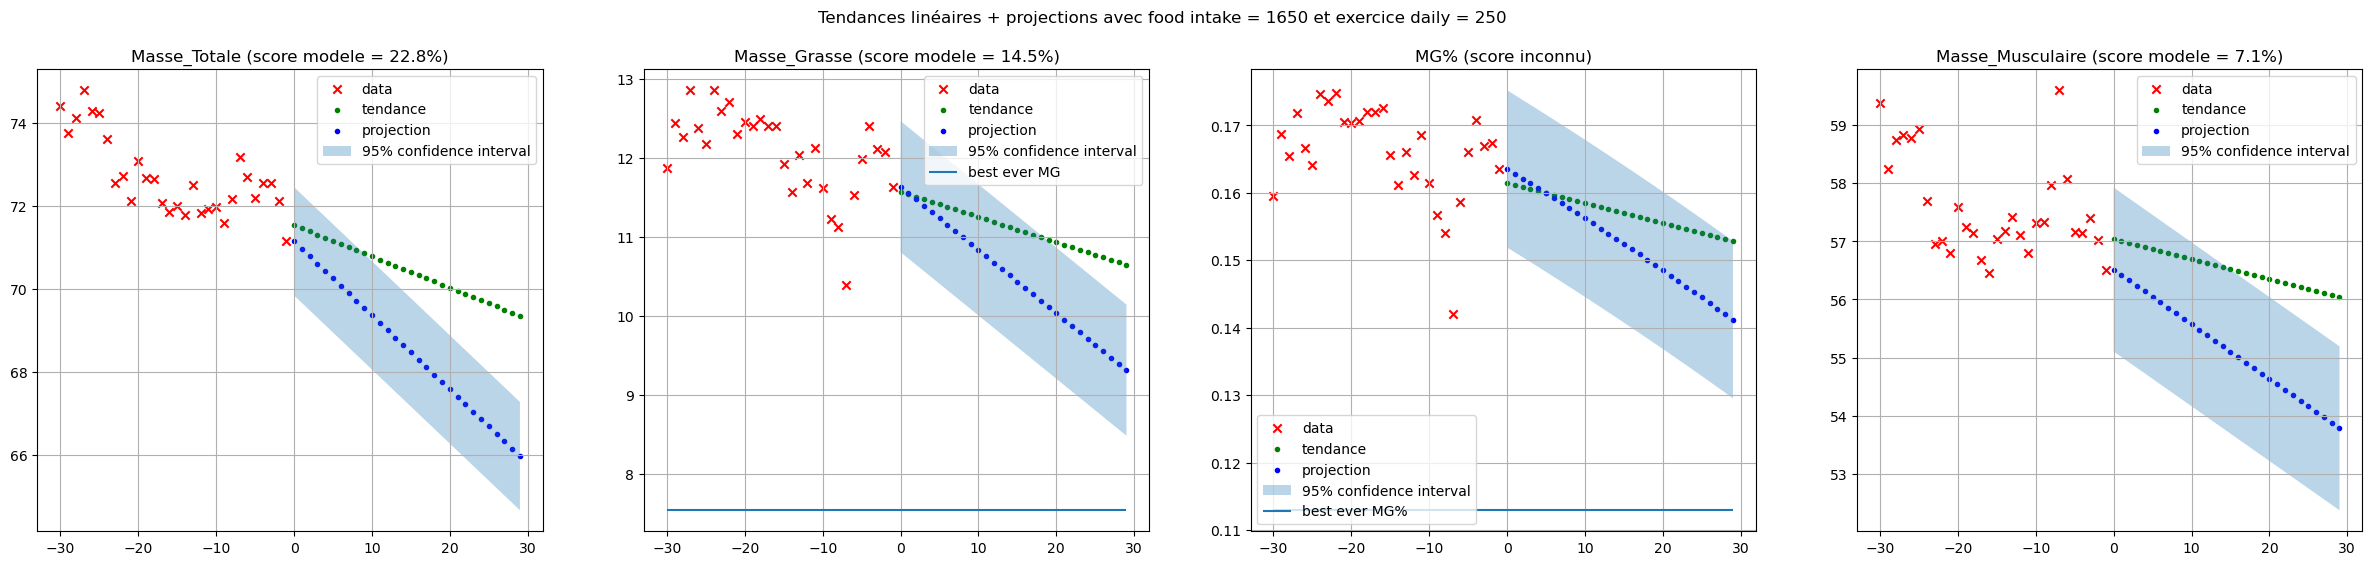

In [24]:
# Indicateurs Masse Totale, Masse Grasse, MG%, Masse Musculaire

X_past = np.array( [i for i in range(-horizon_past,0)] )
X_futur = np.array( [i for i in range(horizon_futur)] )
X = np.array([i for i in range(-horizon_past, horizon_futur)])

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30,6))

for i, name in enumerate(data_columns):
    
    # tendances
    brr = linear_model.BayesianRidge()
    # brr.intercept_ + brr.coef_[0] * food_intake + brr.coef_[1] * exos_avg
    data_past = df_all[name][-horizon_past:].to_numpy()
    brr.fit( X_past.reshape(-1,1), data_past )
    
    data_futur = brr.predict(X_futur.reshape(-1,1))
    
    std = np.sqrt(1/brr.alpha_)
   
    axs[i].scatter(X_past, data_past, marker='x', color='red', label='data')
    axs[i].scatter(X_futur, data_futur, marker='.', color='green', label='tendance')
    if name=='MG%':
        titre = name + ' (score inconnu)'
    else:
        titre = name + ' (score modele = ' + f'{scores[name]*100:.1f}%)'
    axs[i].set_title(titre)
    axs[i].grid(True)
    
    # predictions avec hypothèses food intake et exercices
    if name=='MG%':
        y_pred_mt = np.array([ df_all['Masse_Totale'][-1] + X_futur * daily_delta['Masse_Totale'] ]).reshape(-1,1)
        y_pred_mg = np.array([ df_all['Masse_Grasse'][-1] + X_futur * daily_delta['Masse_Grasse'] ]).reshape(-1,1)
        y_pred = np.array([ y_pred_mg[j] / y_pred_mt[j] for j in list(X_futur)]).reshape(-1,1)
        axs[i].scatter(X_futur, y_pred, marker = '.', label='projection', color='blue')
        y_std = np.array(noises['Masse_Grasse'] / df_all['Masse_Totale'][-1])  # estime une std sur MG%
    else:
        last_y = data_past[-1]
        dd = daily_delta[name]
        y_pred = np.array([ last_y + X_futur * dd ]).reshape(-1,1)
        axs[i].scatter(X_futur, y_pred, marker = '.', label='projection', color='blue')
        y_std = noises[name]
    
    y_min = np.squeeze(y_pred - 1.96 * y_std)
    y_max = np.squeeze(y_pred + 1.96 * y_std)
    axs[i].fill_between(
        X_futur,
        y_min,
        y_max,
        alpha=0.3,
        label=r"95% confidence interval",
    )
    
    if name=='MG%':
        axs[i].hlines(best_ever_mgp, xmin=X_past[0], xmax=X_futur[-1], label = 'best ever MG%')
    if name=='Masse_Grasse':
        axs[i].hlines(best_ever_mg, xmin=X_past[0], xmax=X_futur[-1], label = 'best ever MG')
        
    axs[i].legend()
    
fig.suptitle(f'Tendances linéaires + projections avec food intake = {food_intake:.0f} et exercice daily = {exos_avg:.0f}')

plt.show()

In [25]:
MAX_CAL = 1600.0
PERIODE = 45
n_jours = 15
target = (MAX_CAL*PERIODE - df_food['Calories'][n_jours-PERIODE:].sum())/n_jours
avg = df_food['Calories'][n_jours-PERIODE:].mean()

print(f'Moyenne {PERIODE-n_jours} derniers jours = {avg:.0f} kcals/jour')
print(f'Target quotidienne sur les {n_jours} prochains jours pour tenir {MAX_CAL:.0f} kcals quotidiennes = {target:.0f} kcals/jour')

Moyenne 30 derniers jours = 1813 kcals/jour
Target quotidienne sur les 15 prochains jours pour tenir 1600 kcals quotidiennes = 1174 kcals/jour


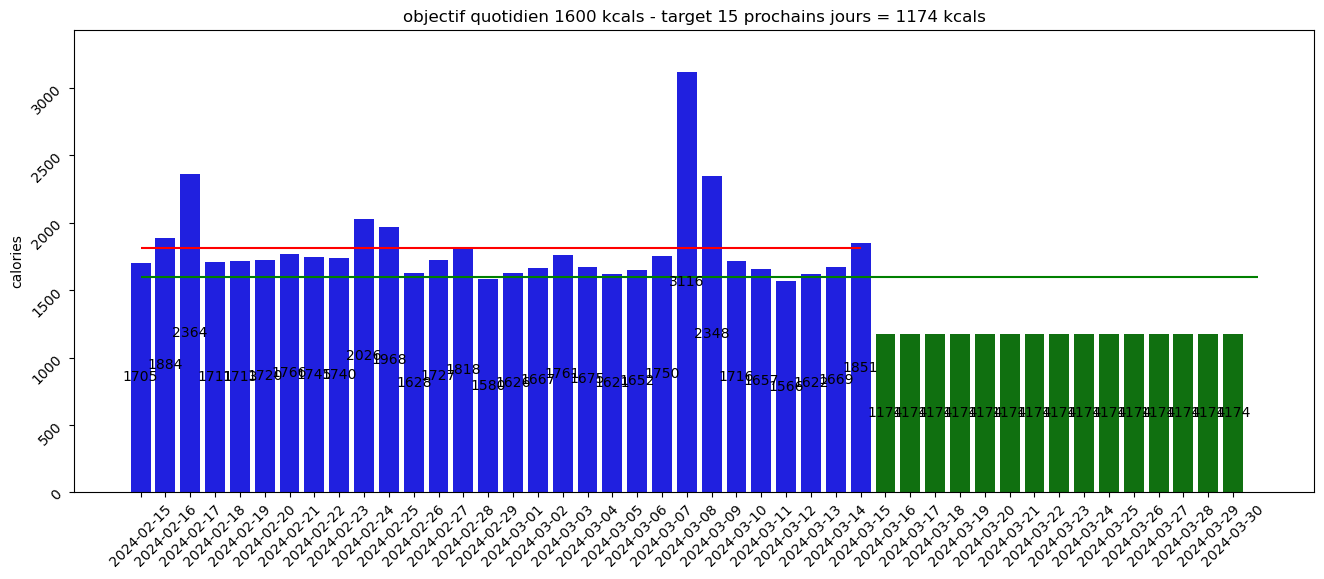

In [26]:
# plot data
fig, ax = plt.subplots(figsize=(16, 6))

tick_label = list(df_food.index[n_jours-PERIODE:]) + [ df_food.index[-1] + datetime.timedelta(days=d) for d in range(1,n_jours+1 )]
listcals = list(df_food['Calories'][n_jours-PERIODE:]) + [ target ] * n_jours

colors = [ 'blue'] * (PERIODE-n_jours) + ['green'] * n_jours
sns.barplot(x=tick_label, y=listcals, ax=ax, palette=colors)

# annotate
ax.bar_label(ax.containers[0], label_type='center', fmt="%.0f")
ax.tick_params(labelrotation=45)

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

ax.set_ylabel('calories')
ax.set_title(f'objectif quotidien {MAX_CAL:.0f} kcals - target {n_jours} prochains jours = {target:.0f} kcals')

ax.hlines(y=avg, xmin=0, xmax=PERIODE-n_jours-1, colors=['red'])
ax.hlines(y=MAX_CAL, xmin=0, xmax=PERIODE, colors=['green'])

plt.show()

# Graphes

In [27]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 'cal_deficit',

dict_hlines = {
        'Calories' : [ (1600, 'green'), (1700, 'orange'), (1800, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [28]:
def plot_general(longueur=15,
                 year=2023,
                 month=11,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

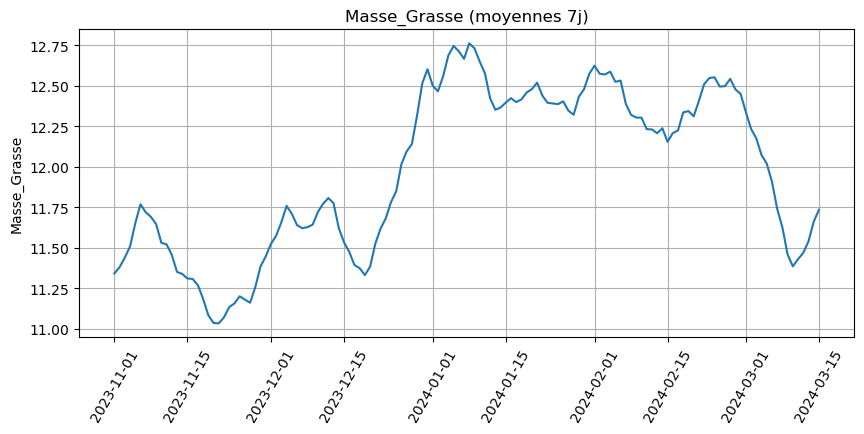

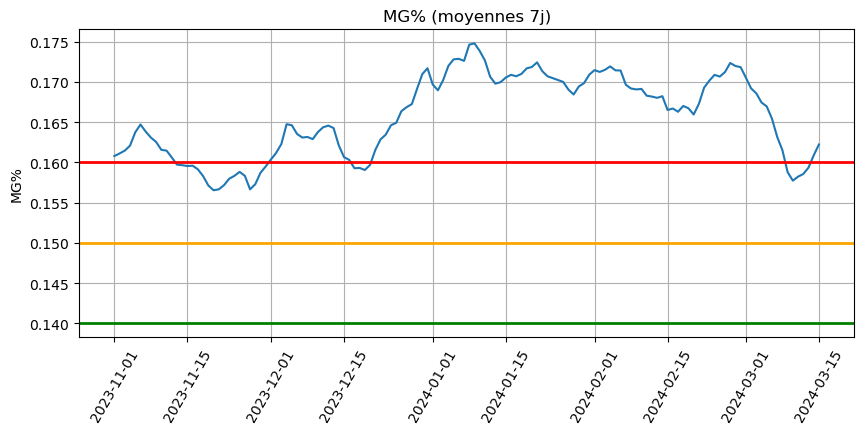

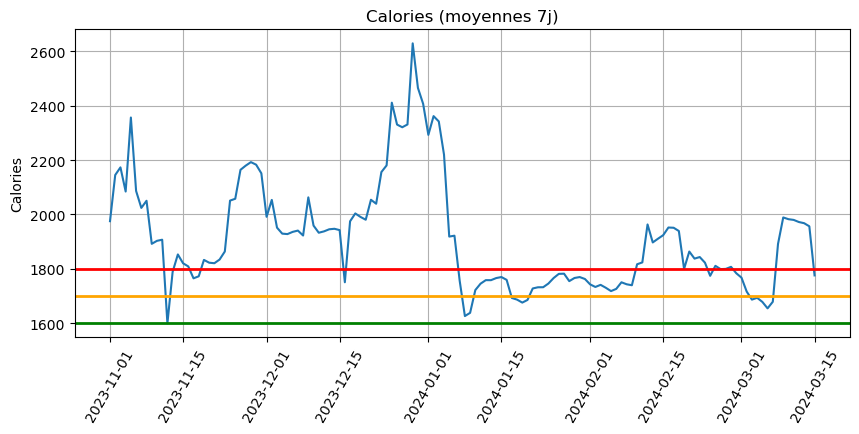

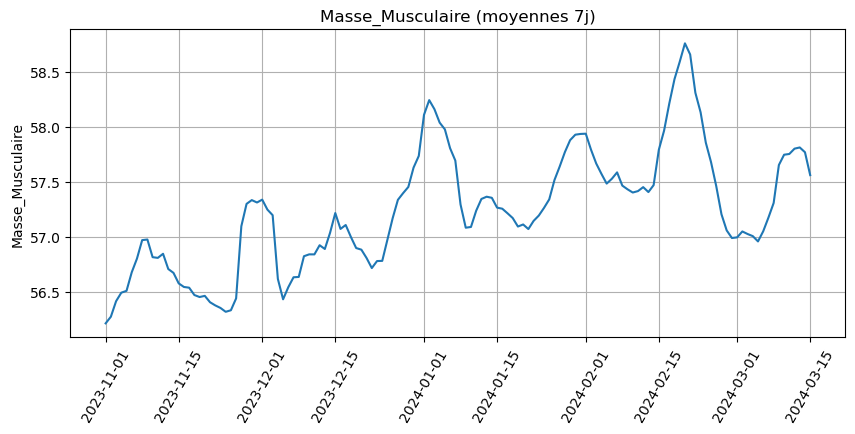

In [29]:
plot_general(longueur=7)

In [30]:
# vars = ['Masse_Grasse', 'MG%', 'Calories','Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire',  'cal_deficit', 

# ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

In [31]:
def plot_general2(longueur=15,
                 year=2023,
                 month=9,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [32]:
# ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [33]:
def plot_general3(longueur=15,
                 year=2023,
                 month=11,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1500.0, top=2500.0)
    # ax2.legend()

In [34]:
# ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [35]:
def scatter_plot(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['cal_deficit'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    # print(delta)
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie deficit over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight change (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=-500, stop=500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')
    

In [36]:
# ipywidgets.interact(scatter_plot, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [37]:
def scatter_plot2(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight variation (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [38]:
# ipywidgets.interact(scatter_plot2, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [39]:
def scatter_plot3(mass_interval=5.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_MG'] = (df_corr['Masse_Grasse'] - df_corr['Masse_Grasse'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_MG'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly fat mass variation over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [40]:
# ipywidgets.interact(scatter_plot3, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))